
# **Carga de datos** 

In [ ]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz

--2022-07-02 11:24:30--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18507440 (18M) [application/x-gzip]
Saving to: ‘reviews_Office_Products_5.json.gz’

reviews_Office_Prod 100%[===================>]  17.65M  3.96MB/s    in 4.7s    

2022-07-02 11:24:35 (3.72 MB/s) - ‘reviews_Office_Products_5.json.gz’ saved [18507440/18507440]



In [ ]:
import json
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import pickle
import re, string
import sys
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pickle
from collections import Counter


In [ ]:
#import pandas as pd
df_office = pd.read_json("reviews_Office_Products_5.json.gz", lines = True, compression='gzip')

# Exploración del Corpus

In [ ]:
df_office.overall.unique()

array([5, 2, 4, 3, 1])

In [ ]:
data = df_office[['reviewText', 'overall']]
data.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [ ]:
data.shape

(53258, 2)

In [ ]:
#No hay datos nulos en el dataset
data.isnull().sum()

In [ ]:
data['overall'].value_counts()

5    30327
4    15015
3     5060
2     1726
1     1130
Name: overall, dtype: int64

Como se puede ver el data set esta muy desbalanceado y con ello voy a entender que si la valoración es superior a 4 estrellas el sentimiento es positivo y sino es negativo. Con esto se obtiene un dataset más balanceado

In [ ]:
def label_sentiment(row):
    if int(row['overall']) < 4:
        return 0
    else:
        return 1

data['sentiment'] = data.apply(lambda row: label_sentiment(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
data.head()

,reviewText,overall,sentiment
0,"I bought my first HP12C in about 1984 or so, a...",5,1
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5,1
2,I have an HP 48GX that has been kicking for mo...,2,0
3,I've started doing more finance stuff recently...,5,1
4,For simple calculations and discounted cash fl...,5,1


In [ ]:
data['sentiment'].value_counts()

1    45342
0     7916
Name: sentiment, dtype: int64

Aquí el data set esta más homogeneo, siendo el valor de 1 sentimiento positivo y 0 sentimiento negativo, ya que sino se tiene un 5 es que le ponemmos algún problema al producto de oficina, en este caso.

Voy a realizar alguna transformación/limpieza en los datos para después poder comparar las visualizaciones con los datos del corpus sin transformar y los transformados/limpiados

**Contar reviews**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Review overall por Rating')

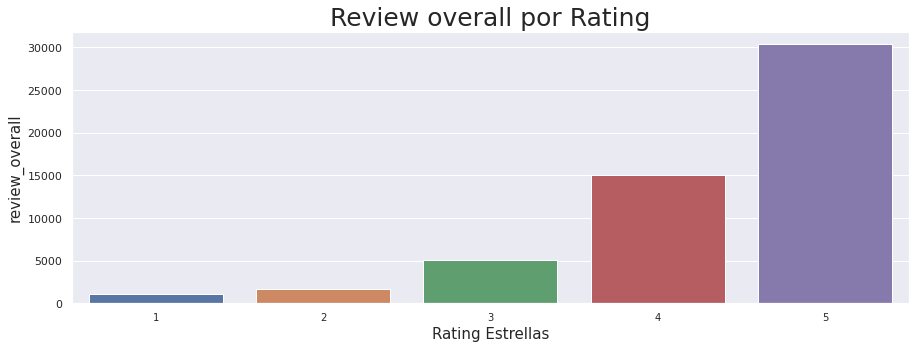

In [ ]:
# Contar por. reviews
rating=pd.DataFrame(data['overall'].value_counts()).reset_index().sort_values(by='index',ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'],rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Estrellas',fontsize=15)
plt.ylabel('review_overall',fontsize=15)
plt.title('Review overall por Rating',fontsize=25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Negativo/Positivo Sentimiento')

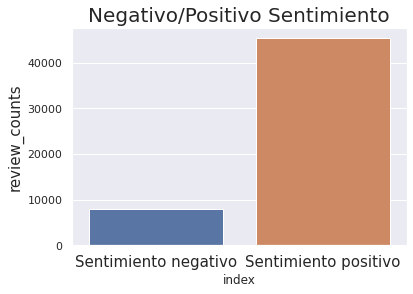

In [ ]:
# contar por sentimiento
bad_good=pd.DataFrame(data['sentiment'].value_counts()).reset_index().sort_values(by='index',ascending=False)

sns.barplot(bad_good['index'],bad_good['sentiment'])
plt.xticks([0,1],["Sentimiento negativo","Sentimiento positivo"],fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Negativo/Positivo Sentimiento',fontsize=20)

**Frecuencia de palabras**

Separo en los datos de sentimiento positivo y negativo

In [ ]:
badsent =data[data.sentiment==0]['reviewText']
goodsent = data[data.sentiment>=1]['reviewText']

In [ ]:
badsent.head()

2     I have an HP 48GX that has been kicking for mo...
25    Too much error code...does not work for me and...
32    These ubiquitous texas instrument calculator t...
34    This is my third Texas Instruments calculator....
37    Overall I do not recommend this product. I rem...
Name: reviewText, dtype: object

In [ ]:
#badsent2 = [s.lower() for s in badsent]

In [ ]:
#badsent2 = [s.replace('\n', ' ') for s in badsent]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#stop_words = nltk.corpus.stopwords.words('english')
#bad_sent=[]
#for w in badsent2:
#  if w not in stop_words:
#    bad_sent.append(w)

In [ ]:
#badsent2=[re.sub('[^A-Za-z0-9]+', ' ', str(i)) for i in badsent2]

In [ ]:
#words_nltk_neg =[i for i in str(bad_sent).split() if i not in stop_words]

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
badsent2 = [s.lower() for s in badsent]
badsent2 = [s.replace('\n', ' ') for s in badsent2]
badsent2=[re.sub('[^A-Za-z0-9]+', ' ', str(i)) for i in badsent2]
words_nltk_pos =[i for i in str(badsent2).split() if i not in stop_words]

Hago una pequeña limpieza de los datos, quitando signos raros, se quitan los espacios para hacer un data set único y se quitan stopwords. 

In [ ]:
goodsent2 = [s.lower() for s in goodsent]
goodsent2 = [s.replace('\n', ' ') for s in goodsent2]
goodsent2=[re.sub('[^A-Za-z0-9]+', ' ', str(i)) for i in goodsent2]
words_nltk_pos =[i for i in str(goodsent2).split() if i not in stop_words]

In [ ]:
wf_neg = Counter(words_nltk_neg)
wf_pos = Counter(words_nltk_pos)

Lo límito a 10 mil datos por tema de memoria

In [ ]:
wf_most_common_neg = wf_neg.most_common(25)
wf_most_common_pos = wf_pos.most_common(25)

In [ ]:
words_pos = [w[0] for w in wf_most_common_pos]
words_neg = [w[0] for w in wf_most_common_neg]
freqs_pos = [w[1] for w in wf_most_common_pos]
freqs_neg = [w[1] for w in wf_most_common_neg]
words_pos = [w[0] for w in wf_most_common_pos]
words_neg = [w[0] for w in wf_most_common_neg]

In [ ]:
freqs_pos, words_pos = zip(*sorted(zip(freqs_pos, words_pos)))
freqs_neg, words_neg = zip(*sorted(zip(freqs_neg, words_neg)))

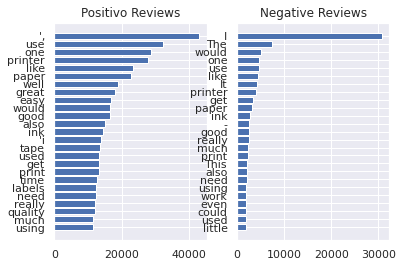

In [ ]:
plt.subplot(1,2,1)
plt.barh(words_pos, freqs_pos)
plt.title("Positivo Reviews")
plt.subplot(1,2,2)
plt.barh(words_neg, freqs_neg)
plt.title("Negative Reviews")

plt.show()

Se tiene que continuar realizando limpieza ya que siguen apareciendo stopwords y letras en mayúscula. Pero si que nos da a simple vista que hay algunas palabras como use que no se pueden usar para discriminar ya que aparece en los dos, pero por ejemplo quality si serviría para saber que puede ser una review positiva.

**Trigramas**

Defino la función que me va a definir los trigramas

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words_good3 = get_top_n_trigram(data[data['sentiment']==1]['reviewText'], 30)
common_words_bad3= get_top_n_trigram(data[data['sentiment']==0]['reviewText'], 30)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


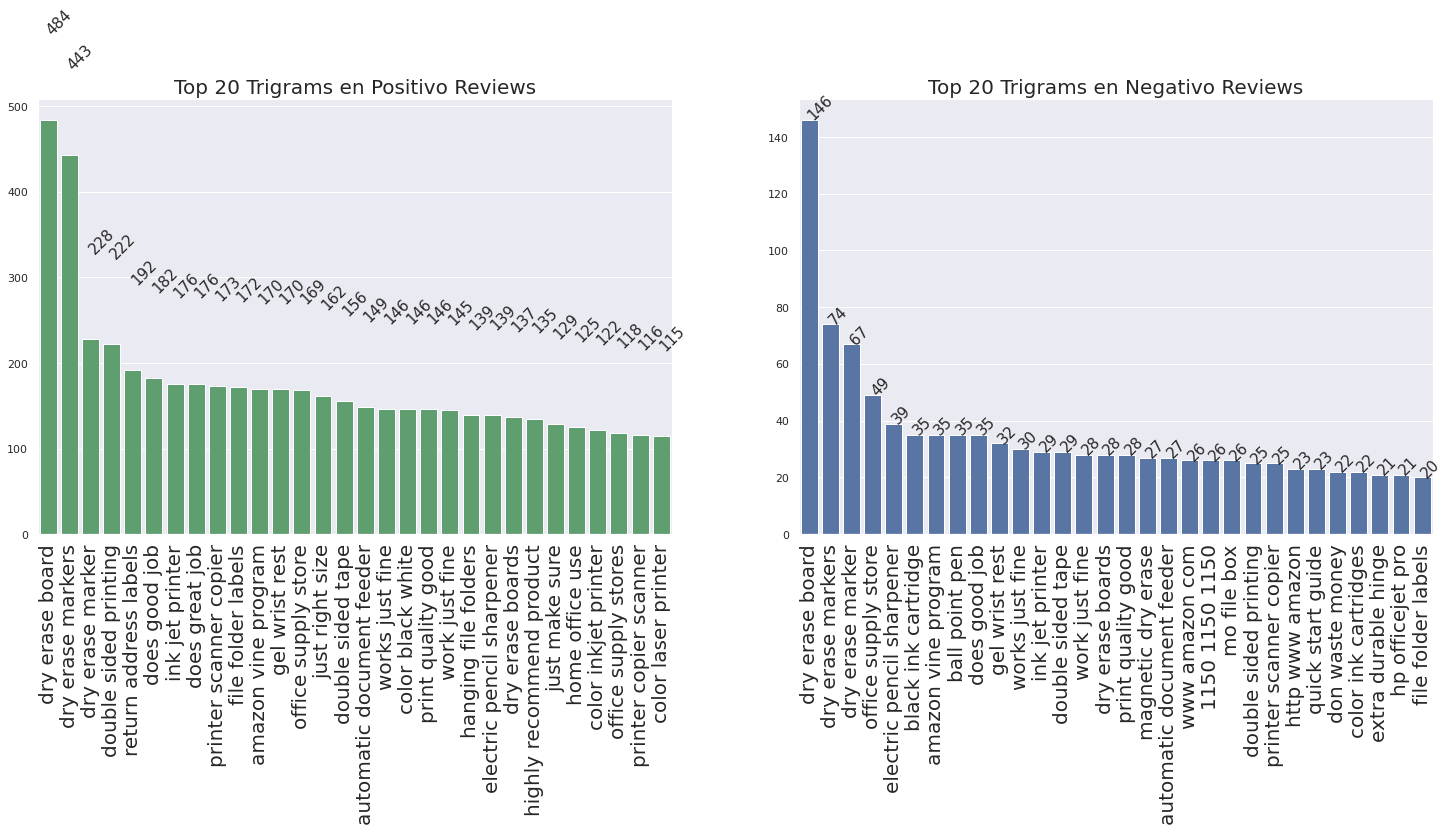

In [ ]:
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
x_good=[x[0] for x in common_words_good3]
y_good=[x[1] for x in common_words_good3]
sns.barplot(x_good,y_good,color='g')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams en Positivo Reviews",fontsize=20)
for i in range(len(x_good)):
    plt.text(i-0.2,y_good[i]+100,'{}'.format(y_good[i]),size=15,rotation=45)
    
plt.subplot(1,2,2)
x_bad=[x[0] for x in common_words_bad3]
y_bad=[x[1] for x in common_words_bad3]
sns.barplot(x_bad,y_bad,color='b')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams en Negativo Reviews",fontsize=20)
for i in range(len(x_bad)):
    plt.text(i-0.2,y_bad[i],'{}'.format(y_bad[i]),size=15,rotation=45)

A simple vista de los trigramas no se puede obtener conclusiones definitivas

**WordCloud**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Worcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  

# get the text based on ratings! 
rating_zero = data['reviewText'][data['sentiment'] == 0]
rating_one = data['reviewText'][data['sentiment'] == 1]

In [ ]:
rating_zero2 = [s.lower() for s in rating_zero]
rating_zero2  = [s.replace('\n', ' ') for s in rating_zero2 ]
rating_zero2 = [re.sub('[^A-Za-z0-9]+', ' ', str(i)) for i in rating_zero2 ]
rating_zero2  =[i for i in str(rating_zero2 ).split() if i not in stop_words]

In [ ]:
rating_one2 = [s.lower() for s in rating_one]
rating_one2 = [s.replace('\n', ' ') for s in rating_one2]
rating_one2=[re.sub('[^A-Za-z0-9]+', ' ', str(i)) for i in rating_one2]
rating_one2 =[i for i in str(goodsent2).split() if i not in stop_words]

In [ ]:
# word tokenize the data 
def list_tokenizer(rating): 
    ratings = " ".join(rating)
    ratings = nltk.word_tokenize(ratings)
    return str(ratings)

# visualizer 
def word_cloud(rating, number): 
    wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)  
    wc.generate(rating)  
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation = 'bilinear')  
    plt.title(f'WordCloud for {number}')
    plt.axis('off');

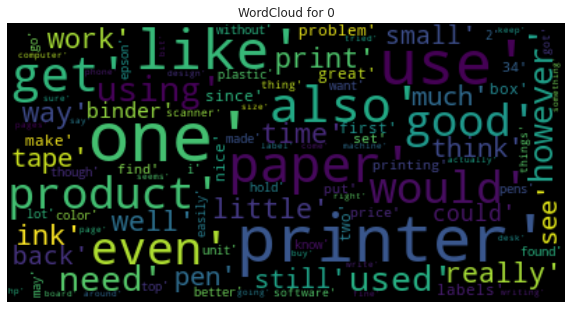

In [ ]:

word_cloud(list_tokenizer(rating_zero2), 0)

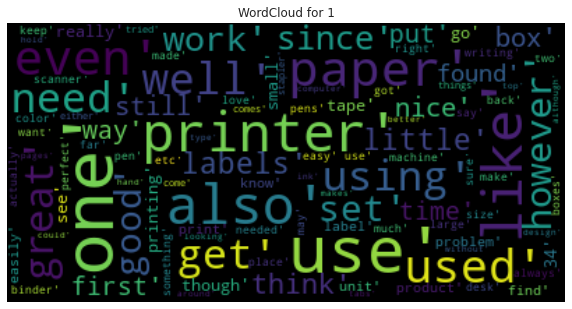

In [ ]:

word_cloud(list_tokenizer(rating_one2), 1)

Conclusión final etapa exploración corpus: De la observación gráfica del corpus a simple vista no se pueden obtener conclusiones, ya que no se observar palabras discriminantes que puedan establecerse que de existir podamos inferir que exprese un sentimiento positivo o negativo

# Preprocesado de texto

In [ ]:
# 1. Mayúsculas a Minúsculas
data3 = data
data3['reviewText'] = data3['reviewText'].str.lower()  # lowering the case! 
data3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviewText,overall,sentiment
0,"i bought my first hp12c in about 1984 or so, a...",5,1
1,why this belated review? i feel very obliged t...,5,1
2,i have an hp 48gx that has been kicking for mo...,2,0
3,i've started doing more finance stuff recently...,5,1
4,for simple calculations and discounted cash fl...,5,1


In [ ]:
# 2. Eliminamos signos de puntuación
data3['reviewText'] = data3['reviewText'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))  # it removes the punctuation 
data3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,overall,sentiment
0,i bought my first hp12c in about 1984 or so an...,5,1
1,why this belated review i feel very obliged to...,5,1
2,i have an hp 48gx that has been kicking for mo...,2,0
3,ive started doing more finance stuff recently ...,5,1
4,for simple calculations and discounted cash fl...,5,1


In [ ]:
# 3. Eliminamos las stopwords

from spacy.lang.en.stop_words import STOP_WORDS
data3['reviewText'] = data3['reviewText'].apply(lambda x: " ".join([i for i in x.split() if i not in STOP_WORDS]) )

data3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,reviewText,overall,sentiment
0,bought hp12c 1984 served faithfully 2002 lost ...,5,1
1,belated review feel obliged share views old wo...,5,1
2,hp 48gx kicking years hp 11 25 years old flawl...,2,0
3,ive started finance stuff recently went lookin...,5,1
4,simple calculations discounted cash flows best...,5,1


In [ ]:
# 4. eliminar url y tags! 
data3['reviewText'] = data3['reviewText'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))
                                              
data3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,overall,sentiment
0,bought hp12c 1984 served faithfully 2002 lost ...,5,1
1,belated review feel obliged share views old wo...,5,1
2,hp 48gx kicking years hp 11 25 years old flawl...,2,0
3,ive started finance stuff recently went lookin...,5,1
4,simple calculations discounted cash flows best...,5,1


In [ ]:
# 5. Modificación ortográfica 
#%time
#from textblob import TextBlob
#data3['reviewText'] = data3['reviewText'].apply(lambda x: TextBlob(x).correct())

#data3.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


KeyboardInterrupt: ignored

Se ha interrupido este código por el tiempo que tardaba de procesamiento

In [ ]:
#6.eleminar espacios en blanco
data3['reviewText'] = data3['reviewText'].apply(lambda x: " ".join(x.split()))
data3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,overall,sentiment
0,bought hp12c 1984 served faithfully 2002 lost ...,5,1
1,belated review feel obliged share views old wo...,5,1
2,hp 48gx kicking years hp 11 25 years old flawl...,2,0
3,ive started finance stuff recently went lookin...,5,1
4,simple calculations discounted cash flows best...,5,1


In [ ]:
# 7. lemmatizar
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
%time
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data3["reviewText"] = data3["reviewText"].apply(lambda text: lemmatize_words(text))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,reviewText,overall,sentiment
0,bought hp12c 1984 served faithfully 2002 lost ...,5,1
1,belated review feel obliged share view old wor...,5,1
2,hp 48gx kicking year hp 11 25 year old flawles...,2,0
3,ive started finance stuff recently went lookin...,5,1
4,simple calculation discounted cash flow best g...,5,1


Ahora hacemos un pipeline en un solo código

In [122]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # Eliminamos las etiquetas HTML
    text = BeautifulSoup(review, "html5lib").get_text()
    # Convertimos a minúscula y quitamos todo lo que no sea texto o números
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Dividimos por espacios
    words = text.split()
    # Eliminamos stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # Aplicamos stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words


In [137]:
import os, json, gzip 
data = []
with gzip.open('reviews_Office_Products_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
df = pd.DataFrame.from_dict(data)

In [148]:
df.overall.value_counts()

5.0    30327
4.0    15015
3.0     5060
2.0     1726
1.0     1130
Name: overall, dtype: int64

In [157]:
sample_size = 1000
df_equal_overall = pd.DataFrame()
for i in df.overall.unique():
  X = df[df.overall == i].sample(sample_size)
  df_equal_overall = df_equal_overall.append(X)

In [158]:
stopwords_list = stopwords.words('english')

def ReviewProcessing(df):
  # remove non alphanumeric 
  df['review_cleaned'] = df.reviewText.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df.review_cleaned = df.review_cleaned.str.lower()
  # split into list
  df.review_cleaned = df.review_cleaned.str.split(' ')
  # remove stopwords
  df.review_cleaned = df.review_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df


In [159]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [160]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [161]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [187]:
clean_data = ReviewProcessing(df_equal_overall)
clean_data.review_cleaned = clean_data.review_cleaned.apply(' '.join)
clean_data['review_cleaned_lemmatized'] = clean_data.review_cleaned.apply(get_lemmatize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [188]:
clean_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_cleaned,review_cleaned_lemmatized
25928,A3MZNRSDQ32UUH,B00347A85S,"imsocrazy ""frenzied reader""","[0, 0]",This was a great package. All the good colors ...,5.0,great,1331856000,"03 16, 2012",great package good colors really need lets fac...,great package good color really need let face ...
9371,A170FHM0QH3SK2,B000GAU2RU,Joan Camilo Granados,"[0, 1]",The pencil is great. If I would have to descri...,5.0,Not that heavy but still hard enough,1366243200,"04 18, 2013",pencil great would describe one word would pro...,pencil great would describe one word would pro...
6268,A137T44OPXY2I2,B0002LCUZK,Ron,"[0, 0]",Holds a lot of papers. Secures them well. Ma...,5.0,Stong and functional,1402531200,"06 12, 2014",holds lot papers secures well made sturdy ma...,hold lot paper secures well make sturdy materi...
48623,A265NE6H6LYX87,B00D7NYHBA,"Tamela Mccann ""taminator40""","[0, 0]",I ordered this for my daughter who will be sta...,5.0,Magnet Combination Board,1405555200,"07 17, 2014",ordered daughter starting college fall loves g...,order daughter start college fall love good si...
5437,A3LZ00UXN4FYVF,B0000AQNM4,Richard Allen,"[0, 0]",A ton of post-it notes. I use these every day ...,5.0,You write things on them and then stick them t...,1383955200,"11 9, 2013",ton postit notes use every day made second cub...,ton postit note use every day make second cube...


In [195]:
data5 = clean_data[['review_cleaned_lemmatized', 'overall']]

In [196]:
data5.overall = data5.overall.apply(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [197]:
data5.head

<bound method NDFrame.head of                                review_cleaned_lemmatized  overall
25928  great package good color really need let face ...        5
9371   pencil great would describe one word would pro...        5
6268   hold lot paper secures well make sturdy materi...        5
48623  order daughter start college fall love good si...        5
5437   ton postit note use every day make second cube...        5
...                                                  ...      ...
24497  dont want premier subscription watch start 3 f...        1
45729  receive download app cell phone ipadwhen try c...        1
42527  would call 34throw away34 stapler cheaply make...        1
45674  good product first thing read user manual indo...        1
2883   found pen write well would recommend even fill...        1

[5000 rows x 2 columns]>

In [182]:
data5 = pd.DataFrame(data5)

In [208]:
def label_sentiment(row):
    if int(row['overall']) < 4:
        return 0
    else:
        return 1

data5['sentiment'] = data5.apply(lambda row: label_sentiment(row), axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [209]:
data5.head()

,review_cleaned_lemmatized,overall,sentiment
25928,great package good color really need let face ...,5,1
9371,pencil great would describe one word would pro...,5,1
6268,hold lot paper secures well make sturdy materi...,5,1
48623,order daughter start college fall love good si...,5,1
5437,ton postit note use every day make second cube...,5,1


In [211]:
pd.DataFrame(data5).to_csv("data5.csv")